## Loading the dataset

In [1]:
import itertools
import numpy as np

from samples.dataset import Dataset
from samples.sources.maps import MAPS

import tensorflow as tf
from tensorflow import keras

dataset = Dataset()
dataset.add_datasource(MAPS('/datasets/audio/maps'))

print('Dataset loaded.')

sample_count = sum(len(note.samples) for note in dataset.notes if note.index > 0)
print('\t{0} samples'.format(sample_count))

Dataset loaded.
	1320 samples


## Defining the training data generator

In [2]:
window_size = 4096
batch_size = 32

class NoteSequence(keras.utils.Sequence):
    def __init__(self, dataset, clip_function, batch_size):
        self.dataset = dataset
        self.clip_function = clip_function
        self.batch_size = batch_size
        
        self.init_epoch()
        
    def init_epoch(self):
        self.epoch_notes = [note for note in dataset.notes if note.has_samples()]
    
    def on_epoch_end(self):
        self.init_epoch()
        
    def __len__(self):
        return int(np.ceil(len(self.epoch_notes) / self.batch_size))
    
    def __getitem__(self, batch_index):
        batch_notes = self.epoch_notes[(batch_index * self.batch_size) : ((batch_index+1) * self.batch_size)]
        x = [self.clip_function(note) for note in batch_notes]
        labels = [note.index for note in batch_notes]
        y = keras.utils.to_categorical(labels, num_classes = (Dataset.MAX_NOTE_INDEX + 1))
        return tf.squeeze(tf.stack(x)), tf.stack(y)
        # return tf.stack(x), tf.stack(y)

random_clips = lambda note : note.random_sample().get_random_clip(window_size)
onset_clips = lambda note : note.random_sample().get_onset_clip(window_size)
note_sequence = NoteSequence(dataset, random_clips, batch_size)

## Building the model

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 2049)              0         
_________________________________________________________________
dense (Dense)                (None, 2048)              4198400   
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dense_2 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 122)               62586     
Total params: 6,883,962
Trainable params: 6,883,962
Non-trainable params: 0
______________________________________________

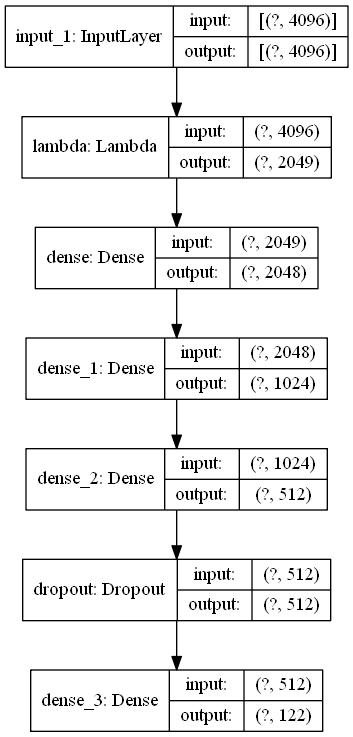

In [3]:
model = keras.Sequential()

model.add(keras.layers.Input(shape=([window_size])))

model.add(keras.layers.Lambda(tf.signal.rfft))

#model.add(keras.layers.Dense(Dataset.MAX_NOTE_INDEX * 100))
model.add(keras.layers.Dense(window_size/2, activation="relu"))
model.add(keras.layers.Dense(window_size/4, activation="relu"))
model.add(keras.layers.Dense(window_size/8, activation="relu"))
#model.add(keras.layers.LeakyReLU(alpha=1e-5))

#model.add(keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu'))
#model.add(keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu'))

#model.add(keras.layers.Dropout(0.2))

#model.add(keras.layers.MaxPooling1D(pool_size=2))
#model.add(keras.layers.Flatten())

model.add(keras.layers.Dropout(0.2))

model.add(keras.layers.Dense(Dataset.MAX_NOTE_INDEX + 1, activation='softmax'))

model.compile(optimizer=keras.optimizers.Adam(clipnorm=1),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()
keras.utils.plot_model(model, show_shapes=True)

## Training

In [4]:
# history = model.fit(xx, yy, epochs=100, use_multiprocessing=True, workers=8)
# history = model.fit(note_sequence, epochs=100, use_multiprocessing=True, workers=8)
history = model.fit(note_sequence, epochs=1000)
# history = model.train_on_batch(xx, yy)

Epoch 1/1000
3/3 [==============================] - 1s 481ms/step - loss: 5.0444 - accuracy: 0.0112
Epoch 2/1000
3/3 [==============================] - 1s 387ms/step - loss: 4.8370 - accuracy: 0.0562
Epoch 3/1000
3/3 [==============================] - 1s 386ms/step - loss: 4.8259 - accuracy: 0.0112
Epoch 4/1000
3/3 [==============================] - 1s 366ms/step - loss: 4.7838 - accuracy: 0.0225
Epoch 5/1000
3/3 [==============================] - 1s 311ms/step - loss: 4.9855 - accuracy: 0.0337
Epoch 6/1000
3/3 [==============================] - 1s 382ms/step - loss: 4.7530 - accuracy: 0.0562
Epoch 7/1000
3/3 [==============================] - 1s 320ms/step - loss: 4.5794 - accuracy: 0.0562
Epoch 8/1000
3/3 [==============================] - 1s 248ms/step - loss: 4.6041 - accuracy: 0.0899
Epoch 9/1000
3/3 [==============================] - 1s 269ms/step - loss: 4.5863 - accuracy: 0.0674
Epoch 10/1000
3/3 [==============================] - 1s 211ms/step - loss: 4.5494 - accuracy: 0.1236

3/3 [==============================] - 0s 26ms/step - loss: 3.4859 - accuracy: 0.2697
Epoch 83/1000
3/3 [==============================] - 0s 25ms/step - loss: 3.4720 - accuracy: 0.2697
Epoch 84/1000
3/3 [==============================] - 0s 26ms/step - loss: 3.1834 - accuracy: 0.2472
Epoch 85/1000
3/3 [==============================] - 0s 25ms/step - loss: 3.6240 - accuracy: 0.2809
Epoch 86/1000
3/3 [==============================] - 0s 26ms/step - loss: 3.2643 - accuracy: 0.3258
Epoch 87/1000
3/3 [==============================] - 0s 26ms/step - loss: 3.2272 - accuracy: 0.3146
Epoch 88/1000
3/3 [==============================] - 0s 28ms/step - loss: 3.4178 - accuracy: 0.2360
Epoch 89/1000
3/3 [==============================] - 0s 26ms/step - loss: 3.6368 - accuracy: 0.2697
Epoch 90/1000
3/3 [==============================] - 0s 25ms/step - loss: 3.7667 - accuracy: 0.3146
Epoch 91/1000
3/3 [==============================] - 0s 26ms/step - loss: 3.1911 - accuracy: 0.3708
Epoch 92/1000


3/3 [==============================] - 0s 27ms/step - loss: 2.9783 - accuracy: 0.3596
Epoch 164/1000
3/3 [==============================] - 0s 28ms/step - loss: 3.1772 - accuracy: 0.3034
Epoch 165/1000
3/3 [==============================] - 0s 28ms/step - loss: 3.1443 - accuracy: 0.3596
Epoch 166/1000
3/3 [==============================] - 0s 28ms/step - loss: 3.4579 - accuracy: 0.4045
Epoch 167/1000
3/3 [==============================] - 0s 29ms/step - loss: 2.7163 - accuracy: 0.4270
Epoch 168/1000
3/3 [==============================] - 0s 28ms/step - loss: 2.9472 - accuracy: 0.3596
Epoch 169/1000
3/3 [==============================] - 0s 28ms/step - loss: 3.2440 - accuracy: 0.4045
Epoch 170/1000
3/3 [==============================] - 0s 29ms/step - loss: 3.4334 - accuracy: 0.3146
Epoch 171/1000
3/3 [==============================] - 0s 28ms/step - loss: 3.1918 - accuracy: 0.3933
Epoch 172/1000
3/3 [==============================] - 0s 27ms/step - loss: 2.5869 - accuracy: 0.3596
Epoch

3/3 [==============================] - 0s 28ms/step - loss: 2.6118 - accuracy: 0.3933
Epoch 245/1000
3/3 [==============================] - 0s 26ms/step - loss: 2.8873 - accuracy: 0.4719
Epoch 246/1000
3/3 [==============================] - 0s 28ms/step - loss: 3.5019 - accuracy: 0.3708
Epoch 247/1000
3/3 [==============================] - 0s 27ms/step - loss: 2.9788 - accuracy: 0.4270
Epoch 248/1000
3/3 [==============================] - 0s 36ms/step - loss: 2.7060 - accuracy: 0.4382
Epoch 249/1000
3/3 [==============================] - 0s 26ms/step - loss: 2.0185 - accuracy: 0.5169
Epoch 250/1000
3/3 [==============================] - 0s 28ms/step - loss: 2.5431 - accuracy: 0.4494
Epoch 251/1000
3/3 [==============================] - 0s 27ms/step - loss: 2.3841 - accuracy: 0.4719
Epoch 252/1000
3/3 [==============================] - 0s 27ms/step - loss: 2.6479 - accuracy: 0.4944
Epoch 253/1000
3/3 [==============================] - 0s 27ms/step - loss: 3.0623 - accuracy: 0.4045
Epoch

3/3 [==============================] - 0s 28ms/step - loss: 2.6251 - accuracy: 0.5281
Epoch 326/1000
3/3 [==============================] - 0s 27ms/step - loss: 2.4310 - accuracy: 0.4607
Epoch 327/1000
3/3 [==============================] - 0s 27ms/step - loss: 2.3414 - accuracy: 0.4944
Epoch 328/1000
3/3 [==============================] - 0s 27ms/step - loss: 2.3582 - accuracy: 0.4944
Epoch 329/1000
3/3 [==============================] - 0s 25ms/step - loss: 2.0967 - accuracy: 0.5056
Epoch 330/1000
3/3 [==============================] - 0s 29ms/step - loss: 2.6217 - accuracy: 0.6180
Epoch 331/1000
3/3 [==============================] - 0s 26ms/step - loss: 2.0564 - accuracy: 0.5169
Epoch 332/1000
3/3 [==============================] - 0s 26ms/step - loss: 2.5736 - accuracy: 0.5169
Epoch 333/1000
3/3 [==============================] - 0s 28ms/step - loss: 2.3290 - accuracy: 0.5056
Epoch 334/1000
3/3 [==============================] - 0s 25ms/step - loss: 2.7054 - accuracy: 0.5169
Epoch

3/3 [==============================] - 0s 28ms/step - loss: 2.4829 - accuracy: 0.5056
Epoch 407/1000
3/3 [==============================] - 0s 25ms/step - loss: 2.6810 - accuracy: 0.5281
Epoch 408/1000
3/3 [==============================] - 0s 26ms/step - loss: 2.1463 - accuracy: 0.5393
Epoch 409/1000
3/3 [==============================] - 0s 26ms/step - loss: 1.9679 - accuracy: 0.5169
Epoch 410/1000
3/3 [==============================] - 0s 27ms/step - loss: 3.1307 - accuracy: 0.4944
Epoch 411/1000
3/3 [==============================] - 0s 25ms/step - loss: 2.8471 - accuracy: 0.5730
Epoch 412/1000
3/3 [==============================] - 0s 26ms/step - loss: 2.1262 - accuracy: 0.4831
Epoch 413/1000
3/3 [==============================] - 0s 26ms/step - loss: 2.2625 - accuracy: 0.5281
Epoch 414/1000
3/3 [==============================] - 0s 27ms/step - loss: 2.1671 - accuracy: 0.5843
Epoch 415/1000
3/3 [==============================] - 0s 27ms/step - loss: 2.4532 - accuracy: 0.4607
Epoch

3/3 [==============================] - 0s 27ms/step - loss: 2.3496 - accuracy: 0.5169
Epoch 488/1000
3/3 [==============================] - 0s 26ms/step - loss: 3.4482 - accuracy: 0.5843
Epoch 489/1000
3/3 [==============================] - 0s 26ms/step - loss: 2.6976 - accuracy: 0.5843
Epoch 490/1000
3/3 [==============================] - 0s 26ms/step - loss: 2.1247 - accuracy: 0.5730
Epoch 491/1000
3/3 [==============================] - 0s 27ms/step - loss: 2.6052 - accuracy: 0.4270
Epoch 492/1000
3/3 [==============================] - 0s 26ms/step - loss: 2.5521 - accuracy: 0.5169
Epoch 493/1000
3/3 [==============================] - 0s 27ms/step - loss: 3.1548 - accuracy: 0.5281
Epoch 494/1000
3/3 [==============================] - 0s 25ms/step - loss: 2.0228 - accuracy: 0.5506
Epoch 495/1000
3/3 [==============================] - 0s 26ms/step - loss: 2.5872 - accuracy: 0.5618
Epoch 496/1000
3/3 [==============================] - 0s 26ms/step - loss: 2.0762 - accuracy: 0.5730
Epoch

3/3 [==============================] - 0s 26ms/step - loss: 2.9222 - accuracy: 0.4831
Epoch 569/1000
3/3 [==============================] - 0s 27ms/step - loss: 2.2059 - accuracy: 0.5955
Epoch 570/1000
3/3 [==============================] - 0s 27ms/step - loss: 2.1762 - accuracy: 0.6517
Epoch 571/1000
3/3 [==============================] - 0s 29ms/step - loss: 1.5839 - accuracy: 0.6404
Epoch 572/1000
3/3 [==============================] - 0s 30ms/step - loss: 2.4467 - accuracy: 0.5730
Epoch 573/1000
3/3 [==============================] - 0s 25ms/step - loss: 1.6037 - accuracy: 0.5955
Epoch 574/1000
3/3 [==============================] - 0s 25ms/step - loss: 2.9793 - accuracy: 0.6067
Epoch 575/1000
3/3 [==============================] - 0s 26ms/step - loss: 2.2592 - accuracy: 0.6404
Epoch 576/1000
3/3 [==============================] - 0s 34ms/step - loss: 2.5162 - accuracy: 0.5955
Epoch 577/1000
3/3 [==============================] - 0s 26ms/step - loss: 2.0106 - accuracy: 0.6292
Epoch

3/3 [==============================] - 0s 28ms/step - loss: 2.5663 - accuracy: 0.6067
Epoch 650/1000
3/3 [==============================] - 0s 26ms/step - loss: 3.4605 - accuracy: 0.6404
Epoch 651/1000
3/3 [==============================] - 0s 25ms/step - loss: 2.0996 - accuracy: 0.6742
Epoch 652/1000
3/3 [==============================] - 0s 26ms/step - loss: 3.0075 - accuracy: 0.5843
Epoch 653/1000
3/3 [==============================] - 0s 28ms/step - loss: 4.7168 - accuracy: 0.5169
Epoch 654/1000
3/3 [==============================] - 0s 27ms/step - loss: 5.5541 - accuracy: 0.4944
Epoch 655/1000
3/3 [==============================] - 0s 26ms/step - loss: 3.5951 - accuracy: 0.5843
Epoch 656/1000
3/3 [==============================] - 0s 27ms/step - loss: 2.5356 - accuracy: 0.5506
Epoch 657/1000
3/3 [==============================] - 0s 26ms/step - loss: 2.8091 - accuracy: 0.5730
Epoch 658/1000
3/3 [==============================] - 0s 25ms/step - loss: 1.9908 - accuracy: 0.6067
Epoch

3/3 [==============================] - 0s 26ms/step - loss: 1.6823 - accuracy: 0.6067
Epoch 731/1000
3/3 [==============================] - 0s 26ms/step - loss: 1.8014 - accuracy: 0.6292
Epoch 732/1000
3/3 [==============================] - 0s 25ms/step - loss: 1.9919 - accuracy: 0.6067
Epoch 733/1000
3/3 [==============================] - 0s 28ms/step - loss: 2.3612 - accuracy: 0.6292
Epoch 734/1000
3/3 [==============================] - 0s 25ms/step - loss: 2.0406 - accuracy: 0.6517
Epoch 735/1000
3/3 [==============================] - 0s 25ms/step - loss: 1.8811 - accuracy: 0.6067
Epoch 736/1000
3/3 [==============================] - 0s 26ms/step - loss: 2.6663 - accuracy: 0.6180
Epoch 737/1000
3/3 [==============================] - 0s 29ms/step - loss: 4.6534 - accuracy: 0.4719
Epoch 738/1000
3/3 [==============================] - 0s 26ms/step - loss: 3.8003 - accuracy: 0.4831
Epoch 739/1000
3/3 [==============================] - 0s 25ms/step - loss: 4.1114 - accuracy: 0.5955
Epoch

3/3 [==============================] - 0s 27ms/step - loss: 1.6956 - accuracy: 0.5393
Epoch 812/1000
3/3 [==============================] - 0s 25ms/step - loss: 2.0953 - accuracy: 0.6404
Epoch 813/1000
3/3 [==============================] - 0s 28ms/step - loss: 2.2994 - accuracy: 0.6180
Epoch 814/1000
3/3 [==============================] - 0s 26ms/step - loss: 1.6820 - accuracy: 0.7191
Epoch 815/1000
3/3 [==============================] - 0s 29ms/step - loss: 3.0240 - accuracy: 0.5730
Epoch 816/1000
3/3 [==============================] - 0s 28ms/step - loss: 2.4537 - accuracy: 0.6180
Epoch 817/1000
3/3 [==============================] - 0s 27ms/step - loss: 1.9527 - accuracy: 0.6742
Epoch 818/1000
3/3 [==============================] - 0s 27ms/step - loss: 2.8232 - accuracy: 0.5730
Epoch 819/1000
3/3 [==============================] - 0s 26ms/step - loss: 1.7084 - accuracy: 0.5955
Epoch 820/1000
3/3 [==============================] - 0s 28ms/step - loss: 1.9378 - accuracy: 0.6742
Epoch

3/3 [==============================] - 0s 25ms/step - loss: 3.2168 - accuracy: 0.5955
Epoch 893/1000
3/3 [==============================] - 0s 27ms/step - loss: 4.5925 - accuracy: 0.5393
Epoch 894/1000
3/3 [==============================] - 0s 25ms/step - loss: 2.6617 - accuracy: 0.6292
Epoch 895/1000
3/3 [==============================] - 0s 25ms/step - loss: 3.4959 - accuracy: 0.5843
Epoch 896/1000
3/3 [==============================] - 0s 26ms/step - loss: 1.4197 - accuracy: 0.6629
Epoch 897/1000
3/3 [==============================] - 0s 26ms/step - loss: 11.9368 - accuracy: 0.6180
Epoch 898/1000
3/3 [==============================] - 0s 25ms/step - loss: 2.3106 - accuracy: 0.5843
Epoch 899/1000
3/3 [==============================] - 0s 25ms/step - loss: 1.7296 - accuracy: 0.6854
Epoch 900/1000
3/3 [==============================] - 0s 25ms/step - loss: 1.7581 - accuracy: 0.6404
Epoch 901/1000
3/3 [==============================] - 0s 26ms/step - loss: 1.7239 - accuracy: 0.6404
Epoc

3/3 [==============================] - 0s 28ms/step - loss: 2.8165 - accuracy: 0.6067
Epoch 974/1000
3/3 [==============================] - 0s 28ms/step - loss: 2.2624 - accuracy: 0.6629
Epoch 975/1000
3/3 [==============================] - 0s 29ms/step - loss: 1.7894 - accuracy: 0.6292
Epoch 976/1000
3/3 [==============================] - 0s 25ms/step - loss: 2.3784 - accuracy: 0.6180
Epoch 977/1000
3/3 [==============================] - 0s 27ms/step - loss: 2.3388 - accuracy: 0.6404
Epoch 978/1000
3/3 [==============================] - 0s 30ms/step - loss: 1.9745 - accuracy: 0.6629
Epoch 979/1000
3/3 [==============================] - 0s 28ms/step - loss: 1.4210 - accuracy: 0.6854
Epoch 980/1000
3/3 [==============================] - 0s 28ms/step - loss: 2.2824 - accuracy: 0.5618
Epoch 981/1000
3/3 [==============================] - 0s 26ms/step - loss: 3.4311 - accuracy: 0.6180
Epoch 982/1000
3/3 [==============================] - 0s 26ms/step - loss: 1.5704 - accuracy: 0.6180
Epoch

## Displaying the training stats

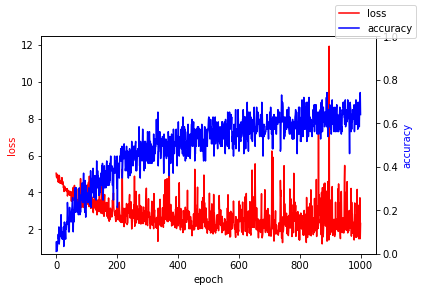

In [5]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()
ax1.set_xlabel('epoch')
ax1.set_ylabel('loss', color='red')

ax2 = ax1.twinx()
ax2.set_ylabel('accuracy', color='blue')
ax2.set_ylim(0, 1)

ax1.plot(history.history['loss'], label='loss', color='red')
ax2.plot(history.history['accuracy'], label='accuracy', color='blue')
fig.legend()
plt.show()

## Evaluating the trained model

In [6]:
import pandas as pd

note_times = [x/1000 for x in range(0, 1000, 10)]

all_samples = ((note.index,
                time,
                [sample.get_clip_at_t(time, window_size) for sample in note.samples],
                [note.index for sample in note.samples]
               )
               for note in dataset.notes if note.index > 0 and note.has_samples() for time in note_times)

scores = [(index,
           time,
           model.evaluate(tf.squeeze(clips), keras.utils.to_categorical(labels, num_classes = (Dataset.MAX_NOTE_INDEX + 1)), verbose=0))
          for (index, time, clips, labels) in all_samples]

score_data = pd.DataFrame(((note, time, score[0], score[1]) for (note, time, score) in scores), columns=['Note', 'Time', 'Loss', 'Accuracy'])

score_data.head()

,Note,Time,Loss,Accuracy
0,10,0.00,15.968262,0.400000
1,10,0.01,11.258683,0.666667
2,10,0.02,2.904358,0.666667
3,10,0.03,4.869132,0.600000
4,10,0.04,16.171824,0.600000


### Plotting the results

<AxesSubplot:xlabel='Time'>

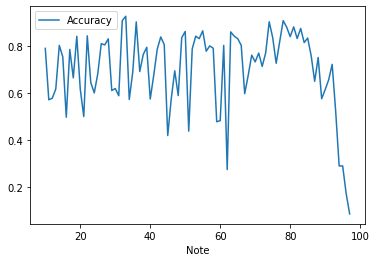

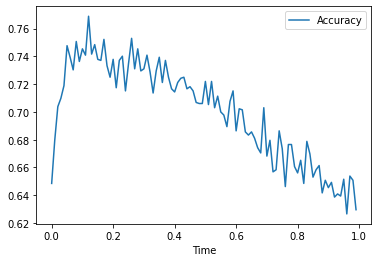

In [7]:
note_accuracy = score_data[['Note', 'Accuracy']].groupby('Note').mean()
note_accuracy.plot()

time_accuracy = score_data[['Time', 'Accuracy']].groupby('Time').mean()
time_accuracy.plot()

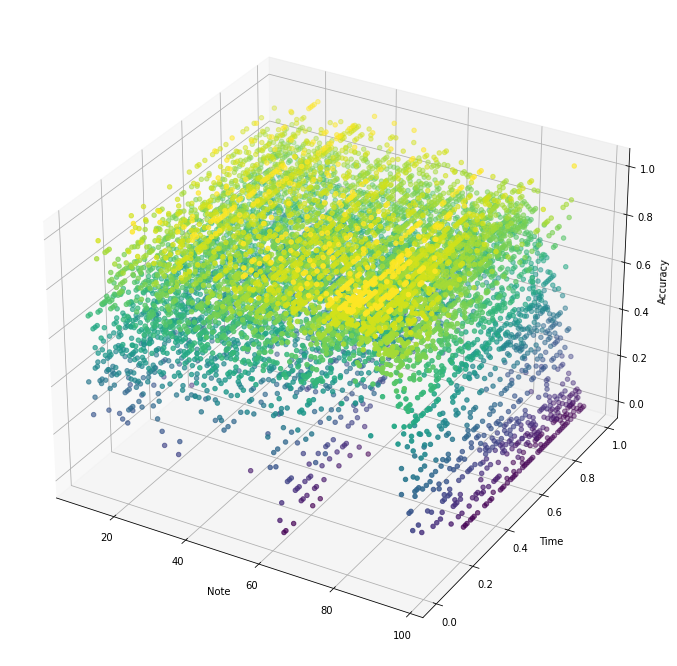

In [8]:
from mpl_toolkits import mplot3d

note_time_accuracy = score_data[['Note', 'Time', 'Accuracy']].groupby(['Note', 'Time'], as_index=False).mean()

fig = plt.figure(figsize=(12, 12))
ax = plt.axes(projection='3d')

ax.scatter3D(note_time_accuracy['Note'],
             note_time_accuracy['Time'],
             note_time_accuracy['Accuracy'],
             c=note_time_accuracy['Accuracy'], cmap='viridis')

ax.set_xlabel('Note')
ax.set_ylabel('Time')
ax.set_zlabel('Accuracy')
plt.show()
